In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

import datetime

from scipy.io import savemat

from cycling_rnn import run_rnn

In [3]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)

In [4]:
def make_pairgrid(d):
    ''' in: (d1,d2,d3,d4) '''
    df = pd.DataFrame(np.concatenate(d))
    cond_labels = d[0].shape[0]*['fw1'] + d[1].shape[0]*['fw2'] + d[2].shape[0]*['bw1'] + d[3].shape[0]*['bw2']
    df['condition'] = cond_labels
    g = sns.PairGrid(df, hue='condition', diag_sharey=True)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.plot)
    dmax = np.max(np.concatenate(d))
    g.add_legend()

In [5]:
monkey='D'

In [6]:
if monkey=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb.mat')
else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb.mat')

In [7]:
m1 = data['D'][0,0]['M1']
emg = data['D'][0,0]['EMG']

m1 = np.reshape(m1, m1.shape[:2]+(4,)) # order = 'C' or 'F'
emg = np.reshape(emg, emg.shape[:2]+(4,)) # order = 'C' or 'F'

m1 = np.transpose(m1, [1,2,0])
emg = np.transpose(emg, [1,2,0])
# Preprocess data
# Normalize EMG
max_ = np.max(emg, axis=(0,1))
min_ = np.min(emg, axis=(0,1))
emg_ = (emg - min_)/(max_ - min_)

# Normalize M1
max_ = np.max(m1, axis=(0,1))
min_ = np.min(m1, axis=(0,1))
m1_ = m1/(max_ - min_ + 5)

# Select times + downsample 
times = np.arange(2000,4000, 25)
m1_ = m1[times]
emg_ = emg_[times]

### load stuff

In [35]:
pth = './saves/D_0717-1702-30/'
x_tf = np.load(pth+'npsaves/x.npy')
y_tf = np.load(pth+'npsaves/y.npy')
print x_tf.shape

(1, 21)


### plot stuff

In [38]:
ii = 0
jj = 0

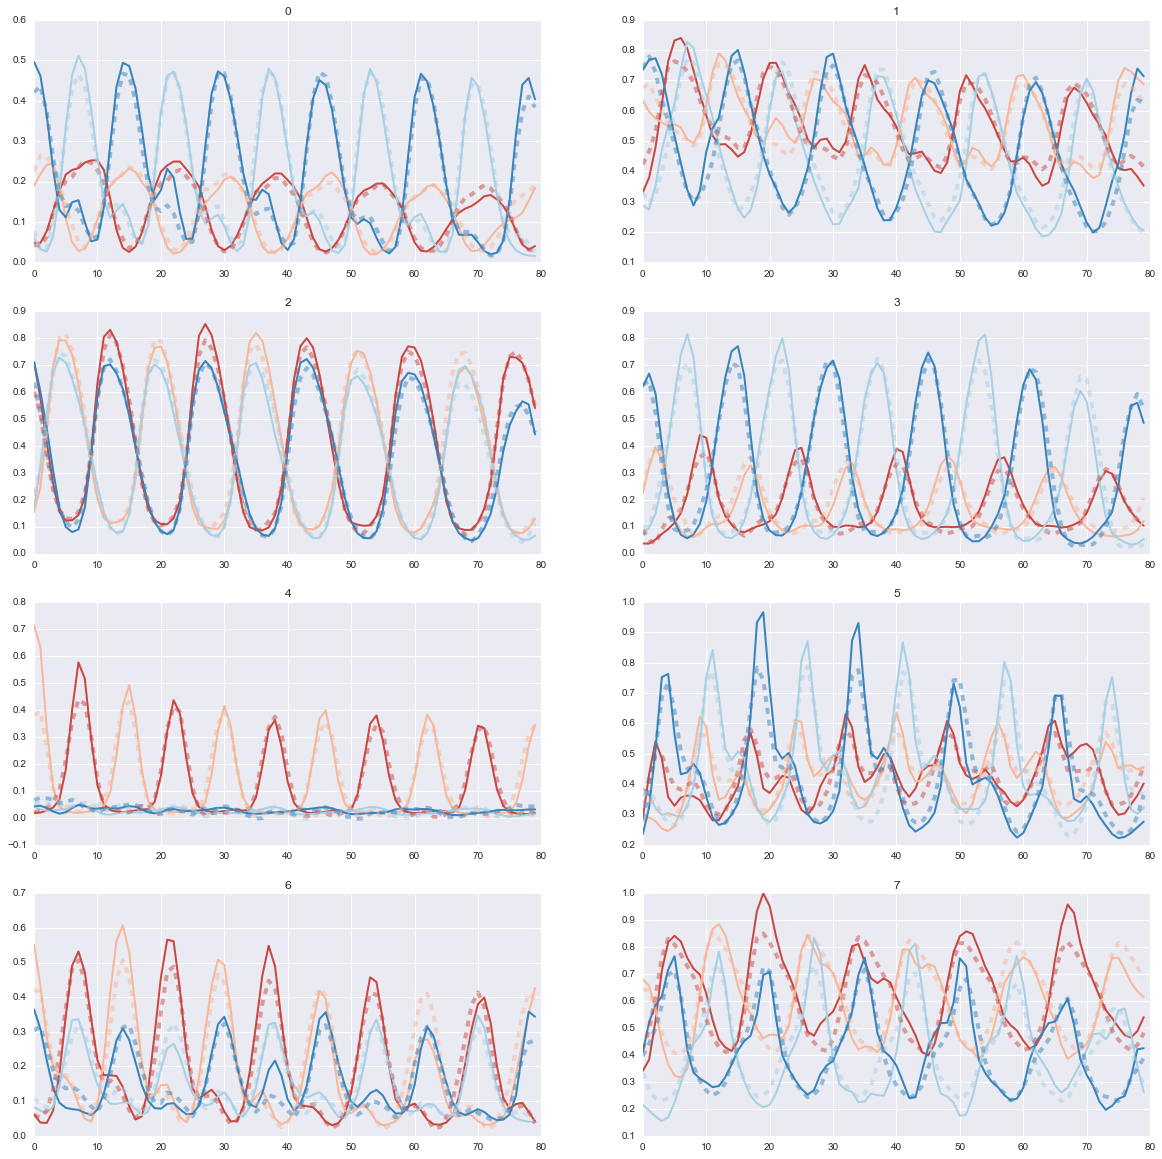

In [39]:
rows = 4
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(20,20))
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg_[:,:,muscle], linewidth=2, alpha=1)
            ax[i,j].plot(y_tf[ii,jj][:,:,muscle],'--',linewidth=4, alpha=0.5)
            ax[i,j].set_title(str(muscle))
plt.show()

## RNN neuron PC plots

In [40]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf[ii,jj][:,i,:] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf[ii,jj][:,i,:] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

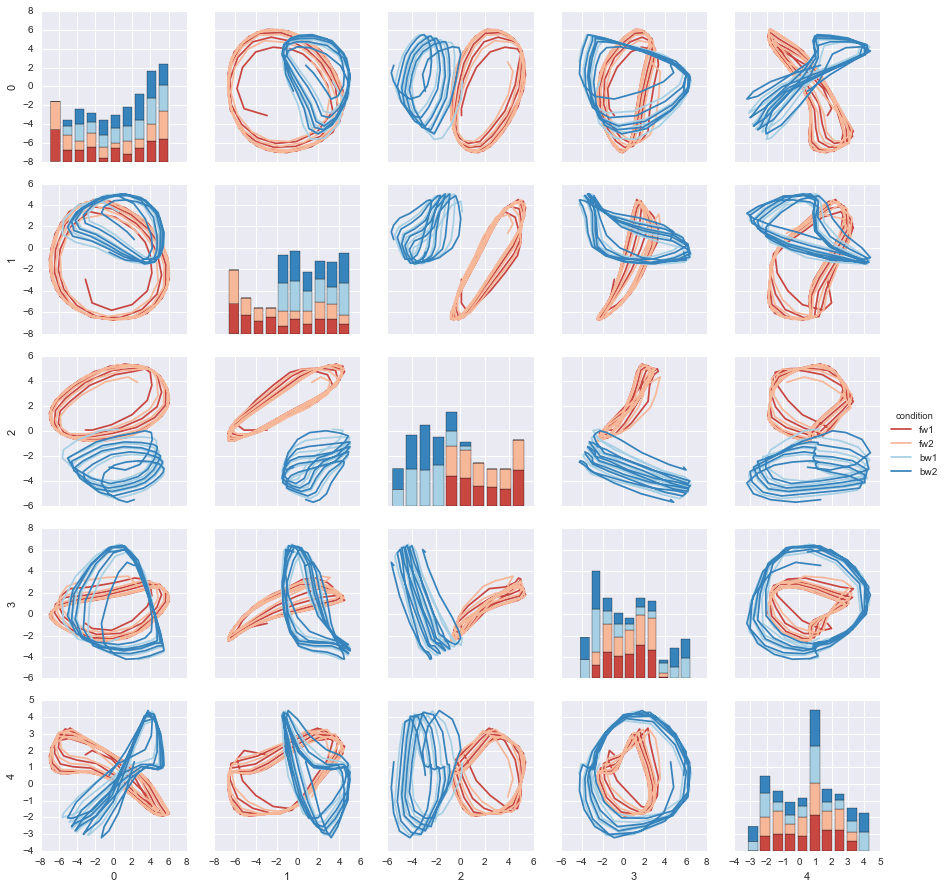

In [41]:
# plot PCs for the RNN state variable
make_pairgrid([np.dot(x_tf[ii,jj][:,i,:], pca_x.components_.T) for i in range(4)])

## RNN activations

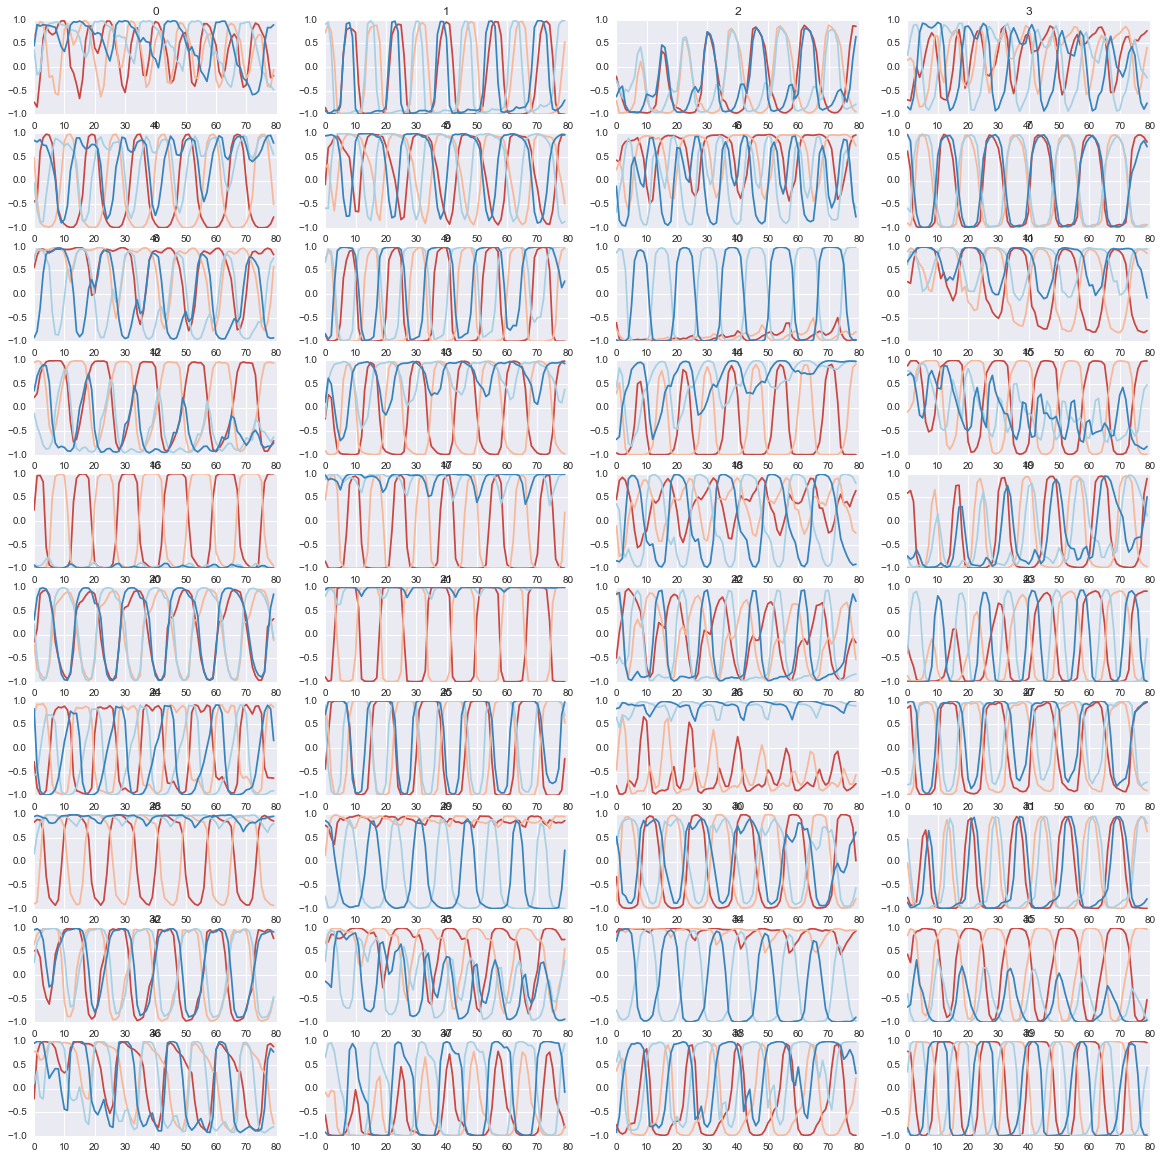

In [42]:
rows = 10
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x_tf[ii,jj][:,:,neuron])
        ax[i,j].set_title(str(neuron))
plt.show()

### load model

In [ ]:
hp_pf = '%02d_%02d' % (ii,jj)
pth+'tfsaves/'+hp_pf

## Plot fit quality

In [ ]:
## need to build graph first, then restore... should do this in rnn_ function
tf.reset_default_graph()

n = 100 # n = 100 neurons
p = 36 # p = 36 muscles
m = 2
batch_size = emg_.shape[1]
time_steps = emg_.shape[0]
beta1 = 0
beta2 = 0
learning_rate = 0.01

x0 = tf.Variable(tf.random_normal([batch_size,n], stddev=0.1), name='x0')

C = tf.Variable(tf.random_normal([n,p], stddev=1/np.sqrt(n)), name='C')
d = tf.Variable(tf.constant(0.01, shape=[1,p]), name='d')

U = tf.placeholder(tf.float32, [time_steps, None, m], name='U')
Y = tf.placeholder(tf.float32, [time_steps, None, p], name='Y')

cell = tf.nn.rnn_cell.BasicRNNCell(n)
#cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
output, state = tf.nn.dynamic_rnn(cell, U, initial_state=x0, dtype=tf.float32, time_major=True)

Y_hat = tf.unpack(output)
Y_hat = [tf.matmul(Y_hat[i], C) + d for i in range(time_steps)]
Y_hat = tf.pack(Y_hat)

with tf.variable_scope('RNN/BasicRNNCell/Linear', reuse=True):
    Mat = tf.get_variable('Matrix', initializer=tf.truncated_normal_initializer(mean=0.0, stddev=1/np.sqrt(n)))
    A = tf.gather(tf.get_variable('Matrix'), range(m, m+n))
    B = tf.gather(tf.get_variable('Matrix'), range(0, m))
    b = tf.get_variable('Bias')

# Training ops
cost = tf.reduce_mean((Y_hat - Y)**2) + beta1*tf.nn.l2_loss(A) + beta2*tf.nn.l2_loss(C)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate)
opt_op = train_op.minimize(cost)

# Summary ops
tf.scalar_summary('loss', cost)
tf.scalar_summary('log_loss', tf.log(cost))
for var in tf.all_variables():
    tf.histogram_summary(var.name, var)
merged_summary_op = tf.merge_all_summaries()

# Saver ops
saver = tf.train.Saver()


In [ ]:
with tf.Session() as sess:
    hp_pf = '%02d_%02d' % (ii,jj)
    tf.train.Saver().restore(sess, pth+'tfsaves/'+hp_pf)
    hp_pf = '%02d_%02d' % (ii,jj)
    #saver.restore(sess, pth+'tfsaves/'+hp_pf)
    var_list = sess.run(tf.all_variables())
    var_name = [tf.all_variables()[i].name for i in range(len(tf.all_variables()))]
    #var_name = sess.run([tf.all_variables()[i].name for i in range(len(tf.all_variables()))])
var_name    

In [ ]:
var = 3
print var_list[var].shape
plt.plot(var_list[var].T)
plt.figure()
sns.heatmap(var_list[var], square=True, cbar=False, xticklabels=False, yticklabels=False)
plt.show()

In [ ]:
np.logspace(-3, 0, 4)

### export to matlab

In [ ]:
'./saves/D_0717-1702-30/'

In [36]:
savestr = '/Users/jeff/Documents/MATLAB/CyclingTask/data/tf_D_0717-1702-30.mat'
savemat(savestr, mdict={'X': x_tf})

In [37]:
x_tf.shape

(1, 21)